# 0. Import

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from tabulate import tabulate

# 1️. Load MNIST dataset

In [2]:
print("Loading MNIST dataset...")
start_time = time.time()

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

print(f"Dataset shape: {X.shape}")  # (70000, 784)
print(f"Labels: {np.unique(y)}")

Loading MNIST dataset...
Dataset shape: (70000, 784)
Labels: [0 1 2 3 4 5 6 7 8 9]


# 2. Split data into train/test sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (56000, 784), Test size: (14000, 784)


# 3. Train baseline Random Forest

In [4]:
print("Training baseline Random Forest...")
baseline_start = time.time()

rf_baseline = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1)
rf_baseline.fit(X_train, y_train)

y_pred_baseline = rf_baseline.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Baseline Macro F1 Score: {baseline_f1:.4f}")

baseline_end = time.time()
print(f"Baseline training + prediction time: {baseline_end - baseline_start:.2f} seconds")

Training baseline Random Forest...
Baseline Accuracy: 0.9689
Baseline Macro F1 Score: 0.9688
Baseline training + prediction time: 60.90 seconds


# 4. Fine-tune Random Forest using GridSearchCV

In [5]:
print("Fine-tuning Random Forest...")
tune_start = time.time()

param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

tune_end = time.time()
print(f"Grid search time: {tune_end - tune_start:.2f} seconds")

Fine-tuning Random Forest...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-validation accuracy: 0.9717
Grid search time: 6732.09 seconds


# 5. Evaluate Tuned Model

Tuned Random Forest Accuracy: 0.9719
Tuned Random Forest Macro F1 Score: 0.9718

Classification Report:
              precision    recall  f1-score   support

           0     0.9888    0.9873    0.9881      1343
           1     0.9856    0.9862    0.9859      1600
           2     0.9533    0.9754    0.9642      1380
           3     0.9661    0.9560    0.9611      1433
           4     0.9693    0.9745    0.9719      1295
           5     0.9801    0.9670    0.9735      1273
           6     0.9857    0.9871    0.9864      1396
           7     0.9694    0.9694    0.9694      1503
           8     0.9617    0.9624    0.9621      1357
           9     0.9589    0.9528    0.9558      1420

    accuracy                         0.9719     14000
   macro avg     0.9719    0.9718    0.9718     14000
weighted avg     0.9720    0.9719    0.9719     14000



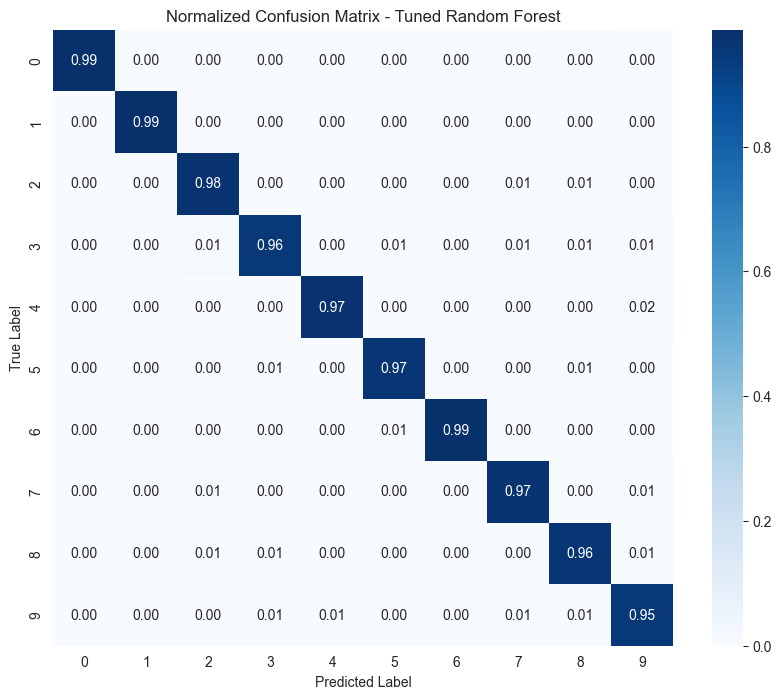

In [6]:
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='macro')

print(f"Tuned Random Forest Accuracy: {accuracy_best:.4f}")
print(f"Tuned Random Forest Macro F1 Score: {f1_best:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, digits=4))

# Normalized Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues')
plt.title("Normalized Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 6. Example Predictions

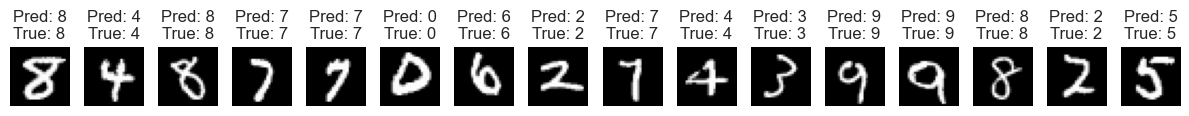

In [7]:
fig, axes = plt.subplots(1, 16, figsize=(12, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Pred: {y_pred_best[i]}\nTrue: {y_test[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# 7. Tree Depth Analysis


🔍 Tree Depth Analysis:
Average tree depth: 37.17
Max tree depth: 51
Min tree depth: 27


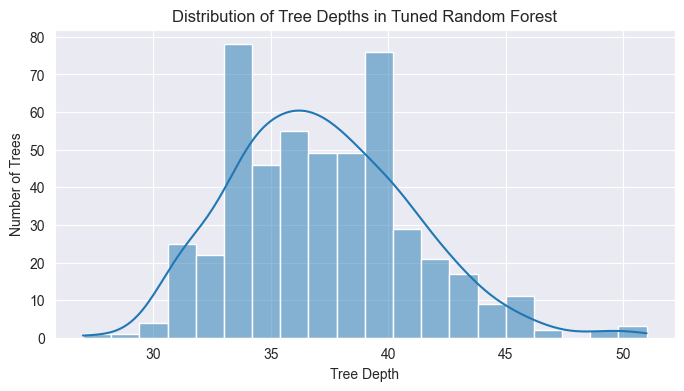

In [8]:
tree_depths = [estimator.tree_.max_depth for estimator in best_rf.estimators_]
avg_depth = np.mean(tree_depths)
max_depth = np.max(tree_depths)
min_depth = np.min(tree_depths)

print("\n🔍 Tree Depth Analysis:")
print(f"Average tree depth: {avg_depth:.2f}")
print(f"Max tree depth: {max_depth}")
print(f"Min tree depth: {min_depth}")

plt.figure(figsize=(8, 4))
sns.histplot(tree_depths, bins=20, kde=True)
plt.title("Distribution of Tree Depths in Tuned Random Forest")
plt.xlabel("Tree Depth")
plt.ylabel("Number of Trees")
plt.show()

# 8. Overview

In [9]:
total_time = time.time() - start_time

summary_data = [
    ["Total Runtime (s)", f"{total_time:.2f}"],
    ["Baseline Training Time (s)", f"{baseline_end - baseline_start:.2f}"],
    ["Grid Search Time (s)", f"{tune_end - tune_start:.2f}"],
    ["Baseline Accuracy", f"{baseline_accuracy:.4f}"],
    ["Best Cross-Validation Accuracy", f"{grid_search.best_score_:.4f}"],
    ["Tuned Model Accuracy", f"{accuracy_best:.4f}"],
    ["Average Tree Depth", f"{avg_depth:.2f}"],
]

print(tabulate(summary_data, headers=["Metric", "Value"], tablefmt="fancy_grid"))

╒════════════════════════════════╤═══════════╕
│ Metric                         │     Value │
╞════════════════════════════════╪═══════════╡
│ Total Runtime (s)              │ 6803.74   │
├────────────────────────────────┼───────────┤
│ Baseline Training Time (s)     │   60.9    │
├────────────────────────────────┼───────────┤
│ Grid Search Time (s)           │ 6732.09   │
├────────────────────────────────┼───────────┤
│ Baseline Accuracy              │    0.9689 │
├────────────────────────────────┼───────────┤
│ Best Cross-Validation Accuracy │    0.9717 │
├────────────────────────────────┼───────────┤
│ Tuned Model Accuracy           │    0.9719 │
├────────────────────────────────┼───────────┤
│ Average Tree Depth             │   37.17   │
╘════════════════════════════════╧═══════════╛
